In [2]:
from libs.edgelistParser import edgelistParser, list2matrix
from libs.page_rank import approximateSimrank, localPageRank
import numpy as np
from matplotlib import pyplot as plt
import heapq as hq
import networkx as nx

In [3]:
# load the Facebook dataset
A, N, D = edgelistParser("datasets/facebook/0.edges")

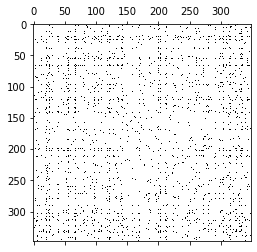

In [4]:
# convert the edge list to a dense matrix
A_mat = list2matrix(A)
plt.figure()
plt.spy(A_mat)
plt.show()

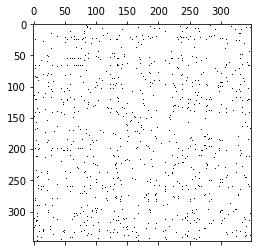

In [5]:
# generate the L matrix
L = localPageRank(A, N, D, c=0.85)
plt.figure()
plt.spy(L)
plt.show()

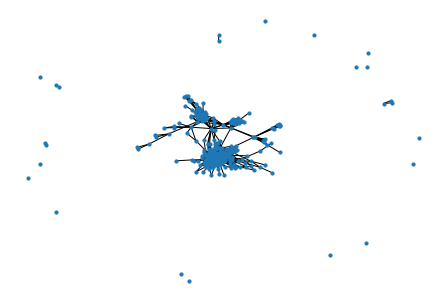

In [8]:
# test the network plot
g = nx.Graph(A_mat)
plt.figure()
nx.draw_spring(g, node_size=10)
plt.show()

In [74]:
# the function computes the network clusters
def cluster(L_norm, centroids, alpha):
    # initialize the cluster output vector
    cluster = np.zeros(L.size)
    # TODO: initialize the clusters
    
    # initialize the cluster heap queues
    queues = []
    
    # insert centroids in the queues, e.g. (expansions, (node, rank))
    for i in range(len(centroids)):
        queue = []
        hq.heappush(queue, (0, (centroids[i], 1)))
        queues.append(queue)
    
    # TODO: comment   
    exit_ext = False
    while not exit_ext:
        for queue in queues:
            # assign the new expansions
            for i, node in enumerate(queue):
                queue[i] = (
                    - alpha*node[1][1],
                    (node[1][0], node[1][1])
                )
            hq.heapify(queue)
        
            # TODO: comment
            exit_int = False
            while not exit_int:
                # pop a node that should be expanded 
                node = hq.heappop(queue)
                
                # check the termination condition
                expansions_opp = node[0]
                if expansions_opp==0:
                    exit_int = True
                else:
                    expansions_opp += 1
                    
                    # TODO: exploit the edgelist to enhance efficiency
                    for neighbour in np.where(L[node[1][0],:]>0): # TODO: correct the missing entries
                        rank = L[node[1][0]]
                        hq.heappush(
                            queue,
                            (
                                np.round(expansions_opp*rank), # TODO: change the round function
                                (neighbour, rank)
                            )
                        ) # TODO: check the min expansion
                
                # TODO: remove
                exit_int = True
        
        # TODO: remove
        exit_ext = True

In [75]:
# TODO: change L with the normalized version
cluster(L, [1, 2], 4)